# 1. Importando bibliotecas e abrindo sessão spark

In [ ]:
%load_ext autoreload
%autoreload 2

from pyspark.sql import SparkSession
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

import sys
sys.path.append('../src/')

from data_processing_functions import *

In [2]:
spark = (SparkSession
    .builder
    .appName("DataUnifier")
    .config("spark.driver.host", "localhost")
    .config("spark.executor.heartbeatInterval","3600s")
    .config("spark.network.timeout","3601s")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "8g")
    .config("spark.sql.shuffle.partitions", "200")
    .getOrCreate()
)


# 2. Explorações e modificações iniciais dos dados

## 2.1. Offers.json

Contém os ids das ofertas e metadados de cada uma delas:

- id (string): id da oferta 
- offer_type (string): o tipo da oferta (BOGO, discount, informational)
    - BOGO: Oferta de "compre um, leve outro". Por exemplo, compre um lanche e ganhe outro grátis
    - discount: Oferta com desconto direto em um produto ou serviço. Exemplo: 20% de desconto em uma compra
    - informational: Não é uma oferta de fato — é só uma mensagem informativa, como anúncios ou lembretes de promoções futuras, sem incentivo direto
- min_value (int): valor mínimo para ativação da oferta 
- duration (int): duração da oferta 
- discount_value (int): valor do desconto 
- channels (list of strings): canais de veiculação 

### 2.1.1. Carregando json das ofertas

In [3]:
offers_ = spark.read.json("../data/raw/offers.json")
offers_.printSchema()
offers_.show()

root
 |-- channels: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- discount_value: long (nullable = true)
 |-- duration: double (nullable = true)
 |-- id: string (nullable = true)
 |-- min_value: long (nullable = true)
 |-- offer_type: string (nullable = true)

+--------------------+--------------+--------+--------------------+---------+-------------+
|            channels|discount_value|duration|                  id|min_value|   offer_type|
+--------------------+--------------+--------+--------------------+---------+-------------+
|[email, mobile, s...|            10|     7.0|ae264e3637204a6fb...|       10|         bogo|
|[web, email, mobi...|            10|     5.0|4d5c57ea9a6940dd8...|       10|         bogo|
|[web, email, mobile]|             0|     4.0|3f207df678b143eea...|        0|informational|
|[web, email, mobile]|             5|     7.0|9b98b8c7a33c4b65b...|        5|         bogo|
|        [web, email]|             5|    10.0|0b1e1539f2cc45b7b.

In [ ]:
# Copia da tabela original
offers = offers_.alias("offers")
offers = offers.withColumnRenamed("id", "offer_id")

### 2.1.2. Contagem de valores dos canais e tipos de oferta

In [5]:
get_values_count(offers, "channels")

get_values_count(offers, "offer_type")

+--------------------+-----+----------+
|            channels|count|percentage|
+--------------------+-----+----------+
|[web, email, mobi...|    4|      40.0|
|[web, email, mobile]|    3|      30.0|
|[email, mobile, s...|    2|      20.0|
|        [web, email]|    1|      10.0|
+--------------------+-----+----------+

None
+-------------+-----+----------+
|   offer_type|count|percentage|
+-------------+-----+----------+
|     discount|    4|      40.0|
|         bogo|    4|      40.0|
|informational|    2|      20.0|
+-------------+-----+----------+

None


DataFrame[offer_type: string, count: bigint, percentage: double]

### 2.1.3. Criando dummies para cada canal

In [6]:
# Coletando todos os canais de veiculação unicos
unique_channels = (offers
    # "Explodindo" os canais para se obter uma coluna com cada um dos canais
    .withColumn("channel", F.explode("channels"))
    .select("channel")
    # Coletando os valores unicos dos canais 
    .distinct()
    .rdd.flatMap(lambda x: x)
    .collect()
)
# Mostrando a lista de canais unicos
print(unique_channels)

# Gerando uma coluna dummie para cada 
for ch in unique_channels:
    offers = offers.withColumn(
        f"channel_{ch}",
        F.when(F.array_contains("channels", ch), 1).otherwise(0)
    )

offers = offers.drop("channels")

# Exibindo a tabela modificada
offers.show()

del(unique_channels, ch)

['mobile', 'email', 'social', 'web']
+--------------+--------+--------------------+---------+-------------+--------------+-------------+--------------+-----------+
|discount_value|duration|            offer_id|min_value|   offer_type|channel_mobile|channel_email|channel_social|channel_web|
+--------------+--------+--------------------+---------+-------------+--------------+-------------+--------------+-----------+
|            10|     7.0|ae264e3637204a6fb...|       10|         bogo|             1|            1|             1|          0|
|            10|     5.0|4d5c57ea9a6940dd8...|       10|         bogo|             1|            1|             1|          1|
|             0|     4.0|3f207df678b143eea...|        0|informational|             1|            1|             0|          1|
|             5|     7.0|9b98b8c7a33c4b65b...|        5|         bogo|             1|            1|             0|          1|
|             5|    10.0|0b1e1539f2cc45b7b...|       20|     discount|    

### 2.1.4. Criando dummies para cada tipo de oferta

In [7]:
offers = create_dummies_for_column(offers, "offer_type")

offers.show()

+--------------+--------+--------------------+---------+-------------+--------------+-------------+--------------+-----------+-------------------+------------------------+---------------+
|discount_value|duration|            offer_id|min_value|   offer_type|channel_mobile|channel_email|channel_social|channel_web|offer_type_discount|offer_type_informational|offer_type_bogo|
+--------------+--------+--------------------+---------+-------------+--------------+-------------+--------------+-----------+-------------------+------------------------+---------------+
|            10|     7.0|ae264e3637204a6fb...|       10|         bogo|             1|            1|             1|          0|                  0|                       0|              1|
|            10|     5.0|4d5c57ea9a6940dd8...|       10|         bogo|             1|            1|             1|          1|                  0|                       0|              1|
|             0|     4.0|3f207df678b143eea...|        0|info

## 2.2. Profile.json

Contém atributos de cerca de 17k clientes:

- age (int): idade do cliente na criação da conta 
- registeredon (int): data de criação da conta 
- gender (string): gênero do cliente 
- id (string): id do cliente 
- credit_card_limit (float): limite do cartão registrado

### 2.2.1. Carregando json dos clientes

In [8]:
profile_ = spark.read.json("../data/raw/profile.json")
profile_.printSchema()
print(profile_.count())
print(profile_.show())

root
 |-- age: long (nullable = true)
 |-- credit_card_limit: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- id: string (nullable = true)
 |-- registered_on: string (nullable = true)

17000
+---+-----------------+------+--------------------+-------------+
|age|credit_card_limit|gender|                  id|registered_on|
+---+-----------------+------+--------------------+-------------+
|118|             NULL|  NULL|68be06ca386d4c319...|     20170212|
| 55|         112000.0|     F|0610b486422d4921a...|     20170715|
|118|             NULL|  NULL|38fe809add3b4fcf9...|     20180712|
| 75|         100000.0|     F|78afa995795e4d85b...|     20170509|
|118|             NULL|  NULL|a03223e636434f42a...|     20170804|
| 68|          70000.0|     M|e2127556f4f64592b...|     20180426|
|118|             NULL|  NULL|8ec6ce2a7e7949b1b...|     20170925|
|118|             NULL|  NULL|68617ca6246f4fbc8...|     20171002|
| 65|          53000.0|     M|389bc3fa690240e79...|     2018020

In [9]:
profile = profile_.alias("profile")

profile = profile.withColumnRenamed("id", "account_id")

### 2.2.2. Investigando possível erro ou falta de dado


In [10]:
# Contagem de nulos entre as colunas de crédito e genero quando a idade é 118
print("Aplicando filtro de 118 anos:")
print(profile.filter(F.col("age") == 118).select(
        F.sum(F.col("credit_card_limit").isNull().cast("int")).alias("credit_card_limit_null"),
        F.sum(F.col("credit_card_limit").isNotNull().cast("int")).alias("credit_card_limit_not_null"),
        F.sum(F.col("gender").isNull().cast("int")).alias("gender_null"),
        F.sum(F.col("gender").isNotNull().cast("int")).alias("gender_not_null")
    ).show()
)

# Contagem de nulos entre as colunas de crédito e genero quando a idade é 118
print("Removendo os perfis com 118 anos:")
print(profile.filter(F.col('age') != 118).select(
        F.sum(F.col("age").isNull().cast("int")).alias("age_null"),
        F.sum(F.col("age").isNotNull().cast("int")).alias("age_not_null"),
        F.sum(F.col("credit_card_limit").isNull().cast("int")).alias("credit_card_limit_null"),
        F.sum(F.col("credit_card_limit").isNotNull().cast("int")).alias("credit_card_limit_not_null"),
        F.sum(F.col("gender").isNull().cast("int")).alias("gender_null"),
        F.sum(F.col("gender").isNotNull().cast("int")).alias("gender_not_null")
    ).show()
)

Aplicando filtro de 118 anos:
+----------------------+--------------------------+-----------+---------------+
|credit_card_limit_null|credit_card_limit_not_null|gender_null|gender_not_null|
+----------------------+--------------------------+-----------+---------------+
|                  2175|                         0|       2175|              0|
+----------------------+--------------------------+-----------+---------------+

None
Removendo os perfis com 118 anos:
+--------+------------+----------------------+--------------------------+-----------+---------------+
|age_null|age_not_null|credit_card_limit_null|credit_card_limit_not_null|gender_null|gender_not_null|
+--------+------------+----------------------+--------------------------+-----------+---------------+
|       0|       14825|                     0|                     14825|          0|          14825|
+--------+------------+----------------------+--------------------------+-----------+---------------+

None


Existe algum erro/falta de dado que ocorre e a idade é definida para 118 anos quando o perfil é gerado.

Quando existe idade, os outros dados também existem.

Portanto vamos trocar o valor 118 por NULL

In [11]:
# Substituindo idade 118 por nulo
profile = profile.withColumn("age",
    F.when(F.col("age") == 118, None)
    .otherwise(F.col("age"))
)
profile.show()

+----+-----------------+------+--------------------+-------------+
| age|credit_card_limit|gender|          account_id|registered_on|
+----+-----------------+------+--------------------+-------------+
|NULL|             NULL|  NULL|68be06ca386d4c319...|     20170212|
|  55|         112000.0|     F|0610b486422d4921a...|     20170715|
|NULL|             NULL|  NULL|38fe809add3b4fcf9...|     20180712|
|  75|         100000.0|     F|78afa995795e4d85b...|     20170509|
|NULL|             NULL|  NULL|a03223e636434f42a...|     20170804|
|  68|          70000.0|     M|e2127556f4f64592b...|     20180426|
|NULL|             NULL|  NULL|8ec6ce2a7e7949b1b...|     20170925|
|NULL|             NULL|  NULL|68617ca6246f4fbc8...|     20171002|
|  65|          53000.0|     M|389bc3fa690240e79...|     20180209|
|NULL|             NULL|  NULL|8974fc5686fe429db...|     20161122|
|NULL|             NULL|  NULL|c4863c7985cf408fa...|     20170824|
|NULL|             NULL|  NULL|148adfcaa27d485b8...|     20150

### 2.2.3. Convertendo string de data de criação para data

In [12]:
profile = (profile
    .withColumn("registered_on", F.to_date(F.col("registered_on").cast("string"), "yyyyMMdd"))
    .withColumn("year_month_joined", F.format_string("%d-%02d", F.year("registered_on"), F.month("registered_on")))
)

profile.show(5)

+----+-----------------+------+--------------------+-------------+-----------------+
| age|credit_card_limit|gender|          account_id|registered_on|year_month_joined|
+----+-----------------+------+--------------------+-------------+-----------------+
|NULL|             NULL|  NULL|68be06ca386d4c319...|   2017-02-12|          2017-02|
|  55|         112000.0|     F|0610b486422d4921a...|   2017-07-15|          2017-07|
|NULL|             NULL|  NULL|38fe809add3b4fcf9...|   2018-07-12|          2018-07|
|  75|         100000.0|     F|78afa995795e4d85b...|   2017-05-09|          2017-05|
|NULL|             NULL|  NULL|a03223e636434f42a...|   2017-08-04|          2017-08|
+----+-----------------+------+--------------------+-------------+-----------------+
only showing top 5 rows



### 2.2.3. Analisando limites de cartão de crédito

Statistical summary of column 'credit_card_limit':
Min: 30,000.0
Max: 120,000.0
Mean: 65,405
Q1 (25%): 49,000.0
Median (Q2 - 50%): 63,000.0
Q3 (75%): 79,000.0
Not null values count: 14,825
Null values count: 2,175


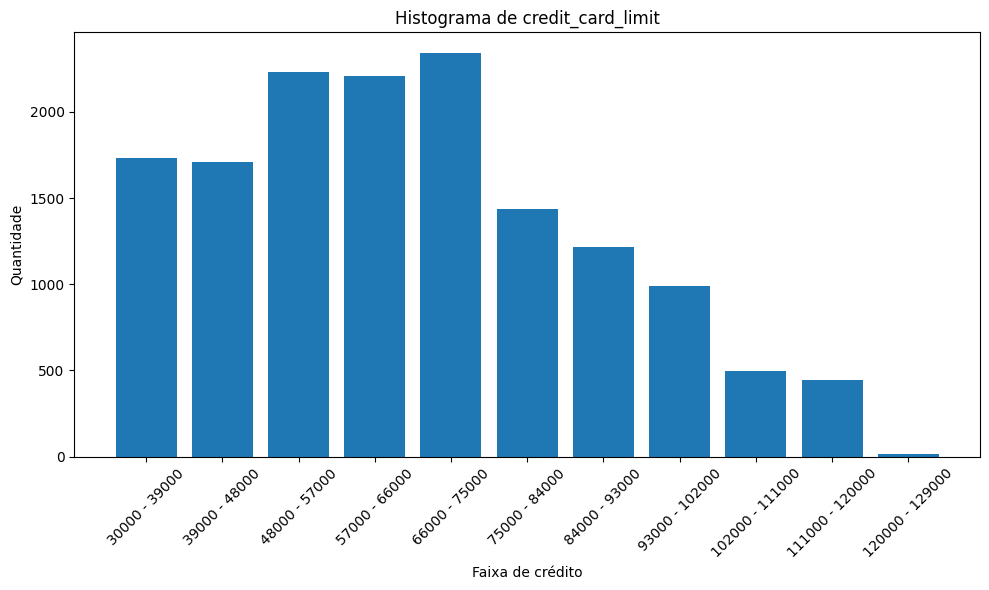

In [13]:
get_numeric_col_summary(profile, "credit_card_limit")

show_histogram_plot(profile, "credit_card_limit", 10)

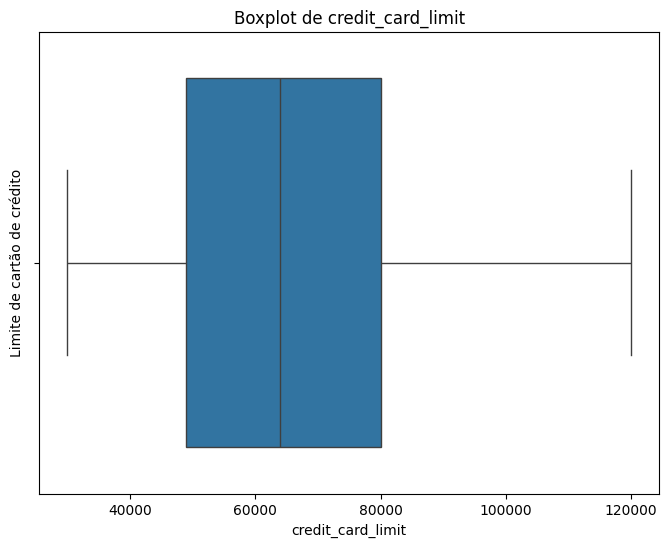

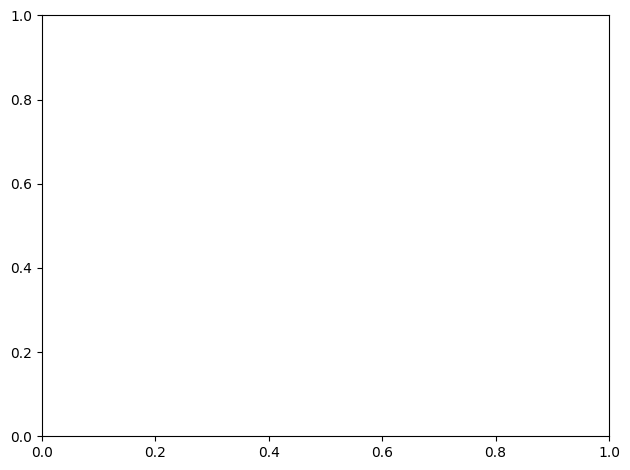

In [ ]:
# Converter para pandas, filtrando nulos
credit_data = profile.select("credit_card_limit", "gender").dropna().toPandas()

# Plotar boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=credit_data, x="credit_card_limit")
plt.title("Boxplot de credit_card_limit")
plt.ylabel("Limite de cartão de crédito")
plt.show()

del(credit_data)

Gerando faixas de limite de cartão de crédito

In [15]:
profile = column_default_categorizer(profile, "credit_card_limit")
profile = create_dummies_for_column(profile, "credit_card_limit")

profile.show()

+----+--------------------+------+--------------------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+
| age|   credit_card_limit|gender|          account_id|registered_on|year_month_joined|credit_card_limit_03_Entre_63000_e_79000|credit_card_limit_02_Entre_49000_e_63000|credit_card_limit_04_Acima_de_79000|credit_card_limit_01_Abaixo_de_49000|credit_card_limit_00_Sem_dados|
+----+--------------------+------+--------------------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+
|NULL|        00_Sem_dados|  NULL|68be06ca386d4c319...|   2017-02-12|          2017-02|                                       0|                                       0|         

### 2.2.4. Criando faixas etárias

In [16]:
profile = (profile
    .withColumn("age",
        F.when(F.col("age") < 18, "01_Abaixo_de_18")
        .when((F.col("age") >= 18) & (F.col("age") <= 29), "02_Entre_18_e_29")
        .when((F.col("age") >= 30) & (F.col("age") <= 39), "03_Entre_30_e_39")
        .when((F.col("age") >= 40) & (F.col("age") <= 49), "04_Entre_40_e_49")
        .when((F.col("age") >= 50) & (F.col("age") <= 59), "05_Entre_50_e_59")
        .when(F.col("age") >= 60, "06_Acima_de_60+")
        .otherwise("00_Sem_dados"))
)

profile = create_dummies_for_column(profile, "age")

get_values_count(profile, "age")

+----------------+-----+----------+
|             age|count|percentage|
+----------------+-----+----------+
| 06_Acima_de_60+| 5875|      34.6|
|05_Entre_50_e_59| 3541|      20.8|
|04_Entre_40_e_49| 2309|      13.6|
|    00_Sem_dados| 2175|      12.8|
|02_Entre_18_e_29| 1574|       9.3|
|03_Entre_30_e_39| 1526|       9.0|
+----------------+-----+----------+

None


DataFrame[age: string, count: bigint, percentage: double]

### 2.2.5. Explorações extras


In [17]:
get_values_count(profile, "gender")

get_values_count(profile, "year_month_joined")

+------+-----+----------+
|gender|count|percentage|
+------+-----+----------+
|     M| 8484|      49.9|
|     F| 6129|      36.1|
|  NULL| 2175|      12.8|
|     O|  212|       1.2|
+------+-----+----------+

None
+-----------------+-----+----------+
|year_month_joined|count|percentage|
+-----------------+-----+----------+
|          2017-10|  900|       5.3|
|          2017-12|  900|       5.3|
|          2017-08|  886|       5.2|
|          2017-09|  836|       4.9|
|          2017-11|  816|       4.8|
|          2018-01|  809|       4.8|
|          2018-03|  618|       3.6|
|          2018-05|  601|       3.5|
|          2018-04|  585|       3.4|
|          2018-06|  562|       3.3|
|          2018-02|  517|       3.0|
|          2018-07|  506|       3.0|
|          2017-07|  404|       2.4|
|          2016-07|  319|       1.9|
|          2017-04|  298|       1.8|
|          2016-03|  308|       1.8|
|          2017-06|  298|       1.8|
|          2016-05|  298|       1.8|
|        

DataFrame[year_month_joined: string, count: bigint, percentage: double]

## 2.3. Transactions.json

Contém cerca de 300k eventos:

- event (str): descrição do evento (transação, oferta recebida, etc.) 
- account_id (str): id do cliente 
- time_since_test_start  (int):  tempo  desde  o  começo  do  teste  em  dias  
(t=0) 
- value (json): registra offer_id, desconto (reward) ou valor da transação

### 2.3.1. Carregando json das transações

In [18]:
transactions_ = spark.read.json("../data/raw/transactions.json")
transactions_.printSchema()
print(transactions_.count())
print(transactions_.show())

root
 |-- account_id: string (nullable = true)
 |-- event: string (nullable = true)
 |-- time_since_test_start: double (nullable = true)
 |-- value: struct (nullable = true)
 |    |-- amount: double (nullable = true)
 |    |-- offer id: string (nullable = true)
 |    |-- offer_id: string (nullable = true)
 |    |-- reward: double (nullable = true)

306534
+--------------------+--------------+---------------------+--------------------+
|          account_id|         event|time_since_test_start|               value|
+--------------------+--------------+---------------------+--------------------+
|78afa995795e4d85b...|offer received|                  0.0|{NULL, 9b98b8c7a3...|
|a03223e636434f42a...|offer received|                  0.0|{NULL, 0b1e1539f2...|
|e2127556f4f64592b...|offer received|                  0.0|{NULL, 2906b810c7...|
|8ec6ce2a7e7949b1b...|offer received|                  0.0|{NULL, fafdcd668e...|
|68617ca6246f4fbc8...|offer received|                  0.0|{NULL, 4d5c57ea9

In [19]:
transactions = transactions_.alias("transactions")

### 2.3.2. Transformando dados

Separando os dados do dicionário em colunas separadas

In [20]:
transactions = (transactions
    .withColumn("amount", F.col("value.amount"))     # Transaction value
    .withColumn("offer id", F.col("value.offer id")) # Offer ID
    .withColumn("offer_id", F.col("value.offer_id")) # Offer ID
    .withColumn("reward", F.col("value.reward"))     # Discounted value
    .drop("value")
)

transactions.show(3)

+--------------------+--------------+---------------------+------+--------------------+--------+------+
|          account_id|         event|time_since_test_start|amount|            offer id|offer_id|reward|
+--------------------+--------------+---------------------+------+--------------------+--------+------+
|78afa995795e4d85b...|offer received|                  0.0|  NULL|9b98b8c7a33c4b65b...|    NULL|  NULL|
|a03223e636434f42a...|offer received|                  0.0|  NULL|0b1e1539f2cc45b7b...|    NULL|  NULL|
|e2127556f4f64592b...|offer received|                  0.0|  NULL|2906b810c7d441179...|    NULL|  NULL|
+--------------------+--------------+---------------------+------+--------------------+--------+------+
only showing top 3 rows



Verificando se offer id e offer_id podem ser combinados

Não serão combinados caso haja perda de informação

Se não houver perda de informação, as coluna serão combinadas para simplificar a estrutura da tabela

In [21]:
(transactions
    .groupBy(F.col("event"))
    .agg(
        F.sum(F.col("offer id").isNull().cast("int")).alias("offer id_null"),
        F.sum(F.col("offer id").isNotNull().cast("int")).alias("offer id_not_null"),
        F.sum(F.col("offer_id").isNull().cast("int")).alias("offer_id_null"),
        F.sum(F.col("offer_id").isNotNull().cast("int")).alias("offer_id_not_null")
)).show()

+---------------+-------------+-----------------+-------------+-----------------+
|          event|offer id_null|offer id_not_null|offer_id_null|offer_id_not_null|
+---------------+-------------+-----------------+-------------+-----------------+
|    transaction|       138953|                0|       138953|                0|
| offer received|            0|            76277|        76277|                0|
|offer completed|        33579|                0|            0|            33579|
|   offer viewed|            0|            57725|        57725|                0|
+---------------+-------------+-----------------+-------------+-----------------+



Com esse resultado, vemos que as colunas "offer id" e "offer_id" não existem ao mesmo tempo, portanto podemos combiná-las

In [22]:
transactions = (transactions
    .withColumn("offer_id", F.coalesce(F.col("offer_id"), F.col("offer id")))
    .drop("offer id")
)
transactions.show(3)

+--------------------+--------------+---------------------+------+--------------------+------+
|          account_id|         event|time_since_test_start|amount|            offer_id|reward|
+--------------------+--------------+---------------------+------+--------------------+------+
|78afa995795e4d85b...|offer received|                  0.0|  NULL|9b98b8c7a33c4b65b...|  NULL|
|a03223e636434f42a...|offer received|                  0.0|  NULL|0b1e1539f2cc45b7b...|  NULL|
|e2127556f4f64592b...|offer received|                  0.0|  NULL|2906b810c7d441179...|  NULL|
+--------------------+--------------+---------------------+------+--------------------+------+
only showing top 3 rows



Verificando distribuicao do custo das transações

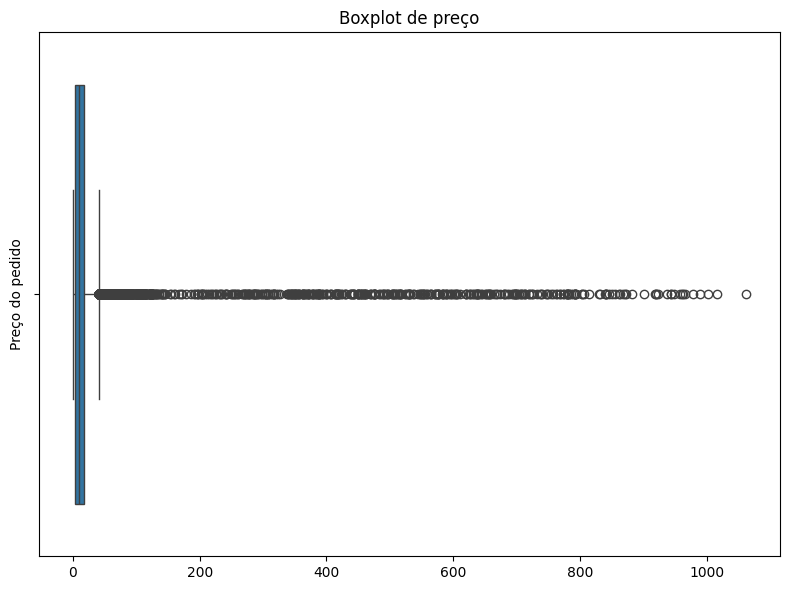

In [23]:
# Converter para pandas, filtrando nulos
temp = transactions.filter(F.col("event") == "transaction").select("amount").dropna().toPandas()

# Plotar violin + boxplot juntos
plt.figure(figsize=(8, 6))
# sns.violinplot(data=transactions, x="credit_card_limit", inner="box", linewidth=1.2)
sns.boxplot(data=temp, x="amount")
plt.title("Boxplot de preço")
plt.ylabel("Preço do pedido")
plt.xlabel("")
plt.tight_layout()
plt.show()

del(temp)

Vemos que os valores de transação podem ser outliers extremos, mas a maioria custa menos do que R$100.

# 3. Combinando dados

Juntando dados de cliente + transações + ofertas

In [24]:
full = (transactions
    # Join com a tabela de ofertas
    .join(
        offers,
        on="offer_id",
        how="left")
    .drop("id")
    # Join com a tabela de clientes
    .join(
        profile,
        on="account_id",
        how="left")
    .drop("id")
)

print(full.count())
print(full.show(3))

offer_received = full.filter(F.col("event") == "offer received")
offer_complete = full.filter(F.col("event") == "offer completed")
offer_viewed = full.filter(F.col("event") == "offer viewed")
transaction = full.filter(F.col("event") == "transaction")

del(full)

306534
+--------------------+--------------------+--------------+---------------------+------+------+--------------+--------+---------+----------+--------------+-------------+--------------+-----------+-------------------+------------------------+---------------+---------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+
|          account_id|            offer_id|         event|time_since_test_start|amount|reward|discount_value|duration|min_value|offer_type|channel_mobile|channel_email|channel_social|channel_web|offer_type_discount|offer_type_informational|offer_type_bogo|            age|   credit_card_limit|gender|registered_on|year_month_joined|credit_card_limit_03_

Juntando dados de oferta, data de visualização e data de recebimento com os dados de transação

In [25]:
# 1. Adicionar dados de oferta às transações #
# Adicionando dados sobre a oferta utilizado (caso tenha sido utilizada naquele dia)
df_joined = transaction.alias("d2").join(
    offer_complete.alias("d1"),
    on=["account_id", "time_since_test_start"],
    how="left"
)

# Lista de colunas (como são iguais nas duas, tudo bem)
cols = transaction.columns

# Aplica coalesce para preencher os nulos de transaction com valores de offer_complete
offer_transaction = df_joined.select(
    *[F.coalesce(F.col(f"d2.{c}"), F.col(f"d1.{c}")).alias(c) for c in cols]
)

del(df_joined, cols, offer_complete)
# 1. --------------------------------------- #

# 2. Selecionando colunas da tabela de envios de ofertas e visualização de ofertas #
offer_r = (offer_received
    .select(
        "time_since_test_start",
        "account_id",
        "offer_id",
        # Veiculação da oferta
        "channel_mobile",
        "channel_email",
        "channel_social",
        "channel_web",
        # Tipo da oferta
        "offer_type")
    .withColumnRenamed('time_since_test_start', 'offer_received_date')
)
offer_v = (offer_viewed
    .select("time_since_test_start","account_id","offer_id")
    .withColumnRenamed('time_since_test_start', 'offer_viewed_date')
)
# 2. ----------------------------------------------------------------------------- #

# 3. Adicionando data na qual a oferta foi recebida #
# Join com dados de data recebida
df_joined = (offer_transaction.alias("p")
    .join(
        # Selecionando apenas as variáveis que interessam para este join
        offer_r.select("offer_received_date","account_id","offer_id").alias("r"),
        on=["account_id", "offer_id"],
        how="left")
    .filter(
        (F.col("r.offer_received_date") <= F.col("p.time_since_test_start"))
        | F.col("p.offer_id").isNull())
)

# Criar janela particionada por evento, ordenada por data descendente
window_spec = Window.partitionBy("p.account_id", "p.offer_id", "p.time_since_test_start").orderBy(F.col("r.offer_received_date").desc())

# Atribuir rank para pegar a mais recente (maior offer_received_date enquanto <= time_since_test_start)
df_ranked = df_joined.withColumn("rank", F.row_number().over(window_spec))

# Filtrar apenas o de rank 1
with_received_date = df_ranked.filter(F.col("rank") == 1).drop("rank")

del(df_joined, offer_transaction, df_ranked)
# 3. ---------------------------------------------- #

# 4. Adicionando data na qual a oferta foi visualizada #
# Step 1: Join com offer_v
df_joined = (with_received_date.alias("p")
    .join(
        offer_v.alias("v"),
        on=["account_id", "offer_id"],
        how="left"
    )
    .filter(
        (F.col("v.offer_viewed_date") <= F.col("p.time_since_test_start"))
        | F.col("p.offer_id").isNull())
)

# Criar janela particionada por evento, ordenada por data descendente
window_spec = Window.partitionBy("p.account_id", "p.offer_id", "p.time_since_test_start").orderBy(F.col("v.offer_viewed_date").desc())

# Atribuir rank para pegar a mais recente (maior offer_viewed_date enquanto <= time_since_test_start)
df_ranked = df_joined.withColumn("rank", F.row_number().over(window_spec))

# Filtrar apenas o de rank 1
df_union = df_ranked.filter(F.col("rank") == 1).drop("rank")

del(df_joined, with_received_date, df_ranked)
# 4. ---------------------------------------------- #

# 5. Criando identificador para uso de oferta #
df_union = (df_union
    .withColumn("used_offer",
        F.when(F.col("offer_id").isNotNull(), 1)
        .otherwise(0))
    .drop("event")
)
# 5. ---------------------------------------- #

# 6. Criando tabela que junta todas as ofertas únicas de cada usuário #
# Realizando um join nas duas tabelas de ofertas recebidas e visualizadas
offer_summary = (offer_r
    .join(offer_v,
        on=["account_id","offer_id"],
        how="left")
    .join(df_union.select("account_id","offer_id","used_offer"),
        on=["account_id","offer_id"],
        how="left")
    .fillna({"used_offer": 0})
    .withColumn('viewed_offer',
        F.when(F.col("offer_viewed_date").isNotNull(), 1)
        .otherwise(0))
)
# Esta tabela offer_summary será utilizada para gerar indicadores de uso de cupons
# E também efetividade de veículação

del(offer_r, offer_v)
# 6. ---------------------------------------------------------------- #

print(df_union.show(10))

print(offer_summary.show(5))

+--------------------+--------------------+---------------------+------+------+--------------+--------+---------+----------+--------------+-------------+--------------+-----------+-------------------+------------------------+---------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+-------------------+-----------------+----------+
|          account_id|            offer_id|time_since_test_start|amount|reward|discount_value|duration|min_value|offer_type|channel_mobile|channel_email|channel_social|channel_web|offer_type_discount|offer_type_informational|offer_type_bogo|             age|   credit_card_limit|gender|registered_on|year_month_joined|credit_

## 3.2. Série temporal das transações

In [26]:
date_grouped = (df_union
    .withColumn("time_since_test_start", F.floor(F.col("time_since_test_start")))
    .groupBy(["time_since_test_start", "used_offer"])
    .agg(
        F.count(F.col("time_since_test_start")).alias("count"),
        F.sum(F.col("amount")).alias("ttl_amount")
    )
    .orderBy(F.col("time_since_test_start").asc(), F.col("used_offer").asc())
)

fig = px.line(
    date_grouped.toPandas(),
    x="time_since_test_start",
    y="count",
    color="used_offer", # uso ou não se oferta
    markers=True, # se quiser mostrar pontos nos valores
    title="Contagem de compras ao longo do periodo com e sem uso de cupom"
)

fig.update_layout(
    xaxis_title="Tempo desde o início do teste",
    yaxis_title="Contagem de eventos",
    template="plotly_dark"
)

fig.show()

del(date_grouped)

Vemos um comportamento sazonal nas transações, a linha que corresponde a ofertas utilizadas (used_offer == 1) cresce quando há uma liberação de oferta, depois de um tempo diminui, pois os usuários gastam seus cupons, porém, muitos cupons anunciados não são utilizados.

# 4. Gerando indicadores para a clusterização

## 4.1. Quantidade e preço médio de transações por cliente

In [27]:
# Adiciona a coluna total_transactions
ttl_transaction_count = (df_union
    .groupBy("account_id")
    .agg(
        F.count("*").alias("total_transactions"),
        F.avg("amount").alias("avg_amount"))
)

profile = (profile
    .join(ttl_transaction_count,
        on="account_id",
        how="left")
)

# Alterando os valores para faixas
profile = column_default_categorizer(profile, "total_transactions")
# Criando dummies da coluna categorizada
profile = create_dummies_for_column(profile, "total_transactions")

# Coletando os quartis
q1, q2, q3, p95 = profile.approxQuantile("avg_amount", [0.25, 0.5, 0.75, 0.95], 0.01)

# Alterando os valores para faixas
profile = (profile
    .withColumn("avg_amount",
        F.when(F.col("avg_amount") <= q1, f"01_Abaixo_de_{round(q1)}")
        .when((F.col("avg_amount") > q1) & (F.col("avg_amount") <= q2), f"02_Entre_{round(q1)}_e_{round(q2)}")
        .when((F.col("avg_amount") > q2) & (F.col("avg_amount") <= q3), f"03_Entre_{round(q2)}_e_{round(q3)}")
        .when((F.col("avg_amount") > q3) & (F.col("avg_amount") <= p95), f"04_Entre_{round(q3)}_e_{round(p95)}")
        .when(F.col("avg_amount") > p95, f"05_Acima_de_{round(p95)}")
        .otherwise(f"00_Sem_dados"))
)

del(q1, q2, q3, p95)

profile = create_dummies_for_column(profile, "avg_amount")

del(ttl_transaction_count)

print(profile.show(5))

+--------------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+------------------+----------------+----------------------------------+---------------------------------+-------------------------------+---------------------------------+---------------------------------+--------------------------+---------------------------+---------------------------+-----------------------+-------------------------+-------------------------+
|          account_id|             age|   credit_card_limit|gender|registered_on|year_month_joined|credit_card_limit_03_Entre_63000_e_79000|credit_card_limit_02_Entre_49000_e_63000|credit_card_limit_04_Acima_de_79000|credit_card_

## 4.2. Tipos de ofertas mais utilizadas por cliente (offer_type)

In [28]:
# Filtrar apenas as linhas com offer_type não nulo
df_offers = df_union.filter(F.col("offer_type").isNotNull())

# Contar quantas vezes cada cliente usou cada tipo de oferta
df_offer_counts = (df_offers
    .groupBy("account_id", "offer_type")
    .agg(F.count("*").alias("offer_type_count"))
)

# Janela para rankear os tipos de oferta mais usados por cliente
window_spec = Window.partitionBy("account_id").orderBy(F.col("offer_type_count").desc())

# Adicionar ranking
df_ranked = df_offer_counts.withColumn("rank", F.row_number().over(window_spec))

# Manter apenas a oferta mais usada por cliente (rank == 1)
df_top_offer_type = (df_ranked
    .filter(F.col("rank") == 1)
    .drop("rank", "offer_type_count")
    .withColumnRenamed("offer_type", "most_used_offer_type")
)

# Join para adicionar dados de oferta mais utilizadas
profile = (profile
    .join(df_top_offer_type,
        on="account_id",
        how="left")
)

# Criando as dummies
profile = create_dummies_for_column(profile, "most_used_offer_type")

print(profile.show(5))

del(df_offers, df_offer_counts, df_ranked, df_top_offer_type)

+--------------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+------------------+----------------+----------------------------------+---------------------------------+-------------------------------+---------------------------------+---------------------------------+--------------------------+---------------------------+---------------------------+-----------------------+-------------------------+-------------------------+--------------------+-----------------------------+-------------------------+-------------------------+
|          account_id|             age|   credit_card_limit|gender|registered_on|year_month_joined|credit_card_limit_03_Entre_

## 4.3. Taxa de pedidos com cupom

In [29]:
# Calcular taxa de uso de cupom por cliente
offer_rate = (df_union
    .groupBy("account_id").agg(
        F.count("*").alias("total_transactions"),
        F.sum(F.col("used_offer")).alias("num_transactions_with_offer"))
    .withColumn(
        "transactions_offer_rate",
        F.col("num_transactions_with_offer") / F.col("total_transactions"))
    .select("account_id", "transactions_offer_rate")
)

# Juntar no profile
profile = (profile
    .join(offer_rate,
        on="account_id",
        how="left")
)

# Alterando os valores para faixas
profile = column_default_categorizer(profile, "transactions_offer_rate", True)
# Criando dummies da coluna categorizada
profile = create_dummies_for_column(profile, "transactions_offer_rate")

print(profile.show(5))

del(offer_rate)

+--------------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+------------------+----------------+----------------------------------+---------------------------------+-------------------------------+---------------------------------+---------------------------------+--------------------------+---------------------------+---------------------------+-----------------------+-------------------------+-------------------------+--------------------+-----------------------------+-------------------------+-------------------------+-----------------------+------------------------------------------+---------------------------------------+--------------------

## 4.4. Tempo médio que usuário demora para utilizar e ver o cupom

In [30]:
# Filtrar e calcular tempo de uso
time_to_use_df = (df_union
    .filter(F.col("used_offer") == 1)
    .withColumn(
        "time_to_use_offer",
        F.col("time_since_test_start") - F.col("offer_received_date"))
    .withColumn(
        "time_to_view_offer",
        F.col("time_since_test_start") - F.col("offer_viewed_date"))
)

# Média de tempo par utilizar cupom por cliente
avg_time_df = (time_to_use_df
    .groupBy("account_id")
    .agg(
        F.avg("time_to_use_offer").alias("avg_time_to_use_offer"),
        F.avg("time_to_view_offer").alias("avg_time_to_view_offer"))
)

# Juntar com profile
profile = (profile
    .join(avg_time_df,
        on="account_id",
        how="left")
)

# Alterando os valores para faixas
profile = column_default_categorizer(profile, "avg_time_to_use_offer")
profile = column_default_categorizer(profile, "avg_time_to_view_offer")
# Criando dummies da coluna categorizada
profile = create_dummies_for_column(profile, "avg_time_to_use_offer")
profile = create_dummies_for_column(profile, "avg_time_to_view_offer")

del(time_to_use_df, avg_time_df)

print(profile.show(5))

+--------------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+------------------+----------------+----------------------------------+---------------------------------+-------------------------------+---------------------------------+---------------------------------+--------------------------+---------------------------+---------------------------+-----------------------+-------------------------+-------------------------+--------------------+-----------------------------+-------------------------+-------------------------+-----------------------+------------------------------------------+---------------------------------------+--------------------

## 4.5. Percentual de cupons utilizados por cliente

### 4.5.1. Geral

In [31]:
# Total de ofertas recebidas por cliente
usage_rate_df = (offer_summary
    .groupBy("account_id")
    .agg(
        F.count("*").alias("total_offers_received"),
        F.sum("used_offer").alias("total_offers_used"))
    # Coluna com porcentagem de uso de cupons
    .withColumn(
        "all_coupon_usage_rate",
        F.col("total_offers_used") / F.col("total_offers_received"))
    .select("account_id", "all_coupon_usage_rate")
)

profile = (profile
    .join(usage_rate_df,
        on="account_id",
        how="left")
)

# Alterando os valores para faixas
profile = column_default_categorizer(profile, "all_coupon_usage_rate", True)
# Criando dummies da coluna categorizada
profile = create_dummies_for_column(profile, "all_coupon_usage_rate")

del(usage_rate_df)

print(profile.show(5))

+--------------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+------------------+----------------+----------------------------------+---------------------------------+-------------------------------+---------------------------------+---------------------------------+--------------------------+---------------------------+---------------------------+-----------------------+-------------------------+-------------------------+--------------------+-----------------------------+-------------------------+-------------------------+-----------------------+------------------------------------------+---------------------------------------+--------------------

### 4.5.2. Por veículo

In [32]:
# Adicionar a informação de uso ao offer_summary
offer_summary_with_usage = (offer_summary.alias("offer_summary_with_usage"))

# Derivar uso por canal
# Multiplicando "used_offer" por cada canal obtemos o resultado de uso da oferta
# quando o canal também é utilizado
for channel in ["mobile", "email", "social", "web"]:
    offer_summary_with_usage = offer_summary_with_usage.withColumn(
        f"used_channel_{channel}",
        F.col("used_offer") * F.col(f"channel_{channel}")
    )

# Agrupar por clientes
offer_summary_with_usage = (offer_summary_with_usage
    .groupBy("account_id")
    .agg(
        F.sum("channel_mobile").alias("total_mobile"),
        F.sum("channel_email").alias("total_email"),
        F.sum("channel_social").alias("total_social"),
        F.sum("channel_web").alias("total_web"),
        F.sum("used_channel_mobile").alias("used_mobile"),
        F.sum("used_channel_email").alias("used_email"),
        F.sum("used_channel_social").alias("used_social"),
        F.sum("used_channel_web").alias("used_web"))
    # Calculo dos percentuais por canal
    .withColumn(
        "pct_used_channel_mobile",
        F.when(F.col("total_mobile") > 0, F.col("used_mobile") / F.col("total_mobile"))
        .otherwise(None))
    .withColumn(
        "pct_used_channel_email",
        F.when(F.col("total_email") > 0, F.col("used_email") / F.col("total_email"))
        .otherwise(None))
    .withColumn(
        "pct_used_channel_social",
        F.when(F.col("total_social") > 0, F.col("used_social") / F.col("total_social"))
        .otherwise(None))
    .withColumn(
        "pct_used_channel_web",
        F.when(F.col("total_web") > 0, F.col("used_web") / F.col("total_web"))
        .otherwise(None))
    # Selecionar apenas colunas de interesse
    .select(
        "account_id",
        "pct_used_channel_mobile",
        "pct_used_channel_email",
        "pct_used_channel_social",
        "pct_used_channel_web")
)

# Juntar com profile
profile = (profile
    .join(offer_summary_with_usage,
        on="account_id",
        how="left")
)

# Alterando os valores para faixas
profile = column_default_categorizer(profile, "pct_used_channel_mobile", True)
profile = column_default_categorizer(profile, "pct_used_channel_email", True)
profile = column_default_categorizer(profile, "pct_used_channel_social", True)
profile = column_default_categorizer(profile, "pct_used_channel_web", True)
# Criando dummies da coluna categorizada
profile = create_dummies_for_column(profile, "pct_used_channel_mobile")
profile = create_dummies_for_column(profile, "pct_used_channel_email")
profile = create_dummies_for_column(profile, "pct_used_channel_social")
profile = create_dummies_for_column(profile, "pct_used_channel_web")

del(offer_summary_with_usage, channel)

print(profile.show(5))

+--------------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+------------------+----------------+----------------------------------+---------------------------------+-------------------------------+---------------------------------+---------------------------------+--------------------------+---------------------------+---------------------------+-----------------------+-------------------------+-------------------------+--------------------+-----------------------------+-------------------------+-------------------------+-----------------------+------------------------------------------+---------------------------------------+--------------------

### 4.5.3. Por tipo

In [33]:
# Adicionar a informação de uso ao offer_summary
offer_summary_with_usage = (offer_summary.alias("offer_summary_with_usage"))

offer_summary_with_usage = (offer_summary
    # Agrupar por cliente e tipo de oferta, contando qtd de ofertas usadas e totais
    .groupBy(["account_id", "offer_type"])
    .agg(
        F.count("*").alias("total_offers"),
        F.sum("used_offer").alias("used_offers"))
    # Calcular percentual
    .withColumn(
        "pct_used_type",
        F.when(F.col("total_offers") > 0, F.col("used_offers") / F.col("total_offers"))
        .otherwise(None))
    .groupBy("account_id")
    # Pivot para deixar cada tipo como uma coluna
    .pivot(
        "offer_type",
        ["bogo", "discount", "informational"])
    .agg(F.first("pct_used_type"))
    # Renomear colunas
    .withColumnRenamed("bogo", "pct_used_type_bogo")
    .withColumnRenamed("discount", "pct_used_type_discount")
    .withColumnRenamed("informational", "pct_used_type_informational")
)

# Join com profile
profile = (profile
    .join(offer_summary_with_usage,
        on="account_id",
        how="left")
)

# Alterando os valores para faixas
profile = column_default_categorizer(profile, "pct_used_type_bogo", True)
profile = column_default_categorizer(profile, "pct_used_type_discount", True)
profile = column_default_categorizer(profile, "pct_used_type_informational", True)
# Criando dummies da coluna categorizada
profile = create_dummies_for_column(profile, "pct_used_type_bogo")
profile = create_dummies_for_column(profile, "pct_used_type_discount")
profile = create_dummies_for_column(profile, "pct_used_type_informational")

del(offer_summary_with_usage)

print(profile.show(5))

+--------------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+------------------+----------------+----------------------------------+---------------------------------+-------------------------------+---------------------------------+---------------------------------+--------------------------+---------------------------+---------------------------+-----------------------+-------------------------+-------------------------+--------------------+-----------------------------+-------------------------+-------------------------+-----------------------+------------------------------------------+---------------------------------------+--------------------

## 4.6. Percentual de cupons visualizados por cliente

### 4.6.1. Geral

In [34]:
# Total de ofertas recebidas por cliente
viewed_rate_df = (offer_summary
    .groupBy("account_id")
    .agg(
        F.count("*").alias("total_offers_received"),
        F.sum("viewed_offer").alias("total_offers_viewed"))
    # Coluna com porcentagem de uso de cupons
    .withColumn(
        "all_coupon_viewed_rate",
        F.col("total_offers_viewed") / F.col("total_offers_received"))
    .select("account_id", "all_coupon_viewed_rate")
)

profile = (profile
    .join(viewed_rate_df,
        on="account_id",
        how="left")
)

# Alterando os valores para faixas
profile = column_default_categorizer(profile, "all_coupon_viewed_rate", True)
# Criando dummies da coluna categorizada
profile = create_dummies_for_column(profile, "all_coupon_viewed_rate")

del(viewed_rate_df)

print(profile.show(5))

+--------------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+------------------+----------------+----------------------------------+---------------------------------+-------------------------------+---------------------------------+---------------------------------+--------------------------+---------------------------+---------------------------+-----------------------+-------------------------+-------------------------+--------------------+-----------------------------+-------------------------+-------------------------+-----------------------+------------------------------------------+---------------------------------------+--------------------

### 4.6.2. Por veículo

In [35]:
# Adicionar a informação de uso ao offer_summary
offer_summary_with_views = (offer_summary.alias("offer_summary_with_views"))

# Derivar uso por canal
# Multiplicando "viewed_offer" por cada canal obtemos o resultado de uso da oferta
# quando o canal também é utilizado
for channel in ["mobile", "email", "social", "web"]:
    offer_summary_with_views = offer_summary_with_views.withColumn(
        f"viewed_channel_{channel}",
        F.col("viewed_offer") * F.col(f"channel_{channel}")
    )

# Agrupar por clientes
offer_summary_with_views = (offer_summary_with_views
    .groupBy("account_id")
    .agg(
        F.sum("channel_mobile").alias("total_mobile"),
        F.sum("channel_email").alias("total_email"),
        F.sum("channel_social").alias("total_social"),
        F.sum("channel_web").alias("total_web"),
        F.sum("viewed_channel_mobile").alias("viewed_mobile"),
        F.sum("viewed_channel_email").alias("viewed_email"),
        F.sum("viewed_channel_social").alias("viewed_social"),
        F.sum("viewed_channel_web").alias("viewed_web"))
    # Calculo dos percentuais por canal
    .withColumn(
        "pct_viewed_channel_mobile",
        F.when(F.col("total_mobile") > 0, F.col("viewed_mobile") / F.col("total_mobile"))
        .otherwise(None))
    .withColumn(
        "pct_viewed_channel_email",
        F.when(F.col("total_email") > 0, F.col("viewed_email") / F.col("total_email"))
        .otherwise(None))
    .withColumn(
        "pct_viewed_channel_social",
        F.when(F.col("total_social") > 0, F.col("viewed_social") / F.col("total_social"))
        .otherwise(None))
    .withColumn(
        "pct_viewed_channel_web",
        F.when(F.col("total_web") > 0, F.col("viewed_web") / F.col("total_web"))
        .otherwise(None))
    # Selecionar apenas colunas de interesse
    .select(
        "account_id",
        "pct_viewed_channel_mobile",
        "pct_viewed_channel_email",
        "pct_viewed_channel_social",
        "pct_viewed_channel_web")
)

# Juntar com profile
profile = (profile
    .join(offer_summary_with_views,
        on="account_id",
        how="left")
)

# Alterando os valores para faixas
profile = column_default_categorizer(profile, "pct_viewed_channel_mobile", True)
profile = column_default_categorizer(profile, "pct_viewed_channel_email", True)
profile = column_default_categorizer(profile, "pct_viewed_channel_social", True)
profile = column_default_categorizer(profile, "pct_viewed_channel_web", True)
# Criando dummies da coluna categorizada
profile = create_dummies_for_column(profile, "pct_viewed_channel_mobile")
profile = create_dummies_for_column(profile, "pct_viewed_channel_email")
profile = create_dummies_for_column(profile, "pct_viewed_channel_social")
profile = create_dummies_for_column(profile, "pct_viewed_channel_web")

del(offer_summary_with_views, channel)

print(profile.show(5))

+--------------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+------------------+----------------+----------------------------------+---------------------------------+-------------------------------+---------------------------------+---------------------------------+--------------------------+---------------------------+---------------------------+-----------------------+-------------------------+-------------------------+--------------------+-----------------------------+-------------------------+-------------------------+-----------------------+------------------------------------------+---------------------------------------+--------------------

### 4.6.3. Por tipo

In [36]:
# Adicionar a informação de uso ao offer_summary
offer_summary_with_views = (offer_summary.alias("offer_summary_with_views"))

offer_summary_with_views = (offer_summary
    # Agrupar por cliente e tipo de oferta, contando qtd de ofertas usadas e totais
    .groupBy(["account_id", "offer_type"])
    .agg(
        F.count("*").alias("total_offers"),
        F.sum("viewed_offer").alias("viewed_offers"))
    # Calcular percentual
    .withColumn(
        "pct_viewed_type",
        F.when(F.col("total_offers") > 0, F.col("viewed_offers") / F.col("total_offers"))
        .otherwise(None))
    .groupBy("account_id")
    # Pivot para deixar cada tipo como uma coluna
    .pivot(
        "offer_type",
        ["bogo", "discount", "informational"])
    .agg(F.first("pct_viewed_type"))
    # Renomear colunas
    .withColumnRenamed("bogo", "pct_viewed_type_bogo")
    .withColumnRenamed("discount", "pct_viewed_type_discount")
    .withColumnRenamed("informational", "pct_viewed_type_informational")
)

# Join com profile
profile = (profile
    .join(offer_summary_with_views,
        on="account_id",
        how="left")
)

# Alterando os valores para faixas
profile = column_default_categorizer(profile, "pct_viewed_type_bogo", True)
profile = column_default_categorizer(profile, "pct_viewed_type_discount", True)
profile = column_default_categorizer(profile, "pct_viewed_type_informational", True)
# Criando dummies da coluna categorizada
profile = create_dummies_for_column(profile, "pct_viewed_type_bogo")
profile = create_dummies_for_column(profile, "pct_viewed_type_discount")
profile = create_dummies_for_column(profile, "pct_viewed_type_informational")

del(offer_summary_with_views)

print(profile.show(5))

+--------------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+------------------+----------------+----------------------------------+---------------------------------+-------------------------------+---------------------------------+---------------------------------+--------------------------+---------------------------+---------------------------+-----------------------+-------------------------+-------------------------+--------------------+-----------------------------+-------------------------+-------------------------+-----------------------+------------------------------------------+---------------------------------------+--------------------

## 4.7. Quantidade de cupons recebidos

### 4.7.1. Geral

In [37]:
# Total de ofertas recebidas por cliente
viewed_rate_df = (offer_summary
    .groupBy("account_id")
    .agg(
        F.count("*").alias("total_offers_received"))
    .select("account_id",
            "total_offers_received")
)

profile = (profile
    .join(viewed_rate_df,
        on="account_id",
        how="left")
)

# Alterando os valores para faixas
profile = column_default_categorizer(profile, "total_offers_received")
# Criando dummies da coluna categorizada
profile = create_dummies_for_column(profile, "total_offers_received")

del(viewed_rate_df)

print(profile.show(5))

+--------------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+------------------+----------------+----------------------------------+---------------------------------+-------------------------------+---------------------------------+---------------------------------+--------------------------+---------------------------+---------------------------+-----------------------+-------------------------+-------------------------+--------------------+-----------------------------+-------------------------+-------------------------+-----------------------+------------------------------------------+---------------------------------------+--------------------

### 4.7.2. Por veículo

In [38]:
# Adicionar a informação de uso ao offer_summary
offer_summary_with_views = (offer_summary.alias("offer_summary_with_views"))

# Derivar uso por canal
# Multiplicando "viewed_offer" por cada canal obtemos o resultado de uso da oferta
# quando o canal também é utilizado
for channel in ["mobile", "email", "social", "web"]:
    offer_summary_with_views = offer_summary_with_views.withColumn(
        f"viewed_channel_{channel}",
        F.col("viewed_offer") * F.col(f"channel_{channel}")
    )

# Agrupar por clientes
offer_summary_with_views = (offer_summary_with_views
    .groupBy("account_id")
    .agg(
        F.sum("channel_mobile").alias("total_mobile_offer"),
        F.sum("channel_email").alias("total_email_offer"),
        F.sum("channel_social").alias("total_social_offer"),
        F.sum("channel_web").alias("total_web_offer"))
    # Selecionar apenas colunas de interesse
    .select(
        "account_id",
        "total_mobile_offer",
        "total_email_offer",
        "total_social_offer",
        "total_web_offer")
)

# Juntar com profile
profile = (profile
    .join(offer_summary_with_views,
        on="account_id",
        how="left")
)

# Alterando os valores para faixas
profile = column_default_categorizer(profile, "total_mobile_offer")
profile = column_default_categorizer(profile, "total_email_offer")
profile = column_default_categorizer(profile, "total_social_offer")
profile = column_default_categorizer(profile, "total_web_offer")
# Criando dummies da coluna categorizada
profile = create_dummies_for_column(profile, "total_mobile_offer")
profile = create_dummies_for_column(profile, "total_email_offer")
profile = create_dummies_for_column(profile, "total_social_offer")
profile = create_dummies_for_column(profile, "total_web_offer")

del(offer_summary_with_views, channel)

print(profile.show(5))

+--------------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+------------------+----------------+----------------------------------+---------------------------------+-------------------------------+---------------------------------+---------------------------------+--------------------------+---------------------------+---------------------------+-----------------------+-------------------------+-------------------------+--------------------+-----------------------------+-------------------------+-------------------------+-----------------------+------------------------------------------+---------------------------------------+--------------------

### 4.7.3. Por tipo

In [39]:
# Adicionar a informação de uso ao offer_summary
offer_summary_with_views = (offer_summary.alias("offer_summary_with_views"))

offer_summary_with_views = (offer_summary
    # Agrupar por cliente e tipo de oferta, contando qtd de ofertas usadas e totais
    .groupBy(["account_id", "offer_type"])
    .agg(
        F.count("*").alias("total_offers"),)
    .groupBy("account_id")
    # Pivot para deixar cada tipo como uma coluna
    .pivot(
        "offer_type",
        ["bogo", "discount", "informational"])
    .agg(F.first("total_offers"))
    # Renomear colunas
    .withColumnRenamed("bogo", "total_offers_bogo")
    .withColumnRenamed("discount", "total_offers_discount")
    .withColumnRenamed("informational", "total_offers_informational")
)

# Join com profile
profile = (profile
    .join(offer_summary_with_views,
        on="account_id",
        how="left")
)

# Alterando os valores para faixas
profile = column_default_categorizer(profile, "total_offers_bogo")
profile = column_default_categorizer(profile, "total_offers_discount")
profile = column_default_categorizer(profile, "total_offers_informational")
# Criando dummies da coluna categorizada
profile = create_dummies_for_column(profile, "total_offers_bogo")
profile = create_dummies_for_column(profile, "total_offers_discount")
profile = create_dummies_for_column(profile, "total_offers_informational")

del(offer_summary_with_views)

print(profile.show(5))

+--------------------+----------------+--------------------+------+-------------+-----------------+----------------------------------------+----------------------------------------+-----------------------------------+------------------------------------+------------------------------+--------------------+--------------------+--------------------+----------------+--------------------+-------------------+------------------+----------------+----------------------------------+---------------------------------+-------------------------------+---------------------------------+---------------------------------+--------------------------+---------------------------+---------------------------+-----------------------+-------------------------+-------------------------+--------------------+-----------------------------+-------------------------+-------------------------+-----------------------+------------------------------------------+---------------------------------------+--------------------

## 4.8. Salvando dados de clientes para serem utilizados na clusterização

In [40]:
profile.toPandas().to_csv('../data/processed/profile_for_clustering.csv', index=False)

# 5. Geração de dados para treino do modelo de probabilidade de uso de ofertas

O modelo de propenção a compra de pedido com oferta terá como features, indicadores similares aos utilizados para clusterização.

In [41]:
offer_summary_4_modeling = (offer_summary
    # Mantendo apenas as ofertas não informacionais
    # por serem as ofertas utilizáveis
    .filter(F.col("offer_type") != "informational")
)

## 5.1. Oferta visualizada em quantos dias após ser recebida

Essa informação não será utilizada no modelo por enquanto, mas a criação da variável já está pronta caso seja necessário no futuro

In [42]:
offer_summary_4_modeling = (offer_summary_4_modeling
    .withColumn("time_to_see_offer",
        F.col("offer_viewed_date") - F.col("offer_received_date")
    )
)

## 5.2. Oferta informacional visualizada nos últimos N dias

In [43]:
# Ofertas apenas informacionais
info_offers = (offer_summary
    # Filtrando apenas ofertas informacionais
    .filter(F.col("offer_type") == "informational")
    # Selecionando apenas coluna de id do cliente e data na qual a oferta foi visualizada
    .select("account_id", "offer_viewed_date") 
    .withColumnRenamed("offer_viewed_date", "info_offer_viewed_date")
)

# Join com condição de ter sido vista a pelo menos 3 dias
offer_summary_4_modeling = (offer_summary_4_modeling.alias("os4m")
    .join(info_offers.alias("io"),
        (F.col("os4m.account_id") == F.col("io.account_id")) &
        # Aplicando filtro para considerar apenas linhas dentro das condições:
        # 1. Informacional a pelo menos 3 dias
        (F.col("io.info_offer_viewed_date") >= (F.col("os4m.offer_received_date") - 3)) &
        # 2. Informacional antes da oferta
        (F.col("io.info_offer_viewed_date") < F.col("os4m.offer_received_date")),
        how="left"
    )
    .withColumn("recently_viewed_info_offer",
        F.when(F.col("io.info_offer_viewed_date").isNotNull(), F.lit(1))
        .otherwise(F.lit(0)))
    .drop("info_offer_viewed_date")
)

del(info_offers)

print(offer_summary_4_modeling.show(3))

+--------------------+--------------------+-------------------+--------------+-------------+--------------+-----------+----------+-----------------+----------+------------+-----------------+----------+--------------------------+
|          account_id|            offer_id|offer_received_date|channel_mobile|channel_email|channel_social|channel_web|offer_type|offer_viewed_date|used_offer|viewed_offer|time_to_see_offer|account_id|recently_viewed_info_offer|
+--------------------+--------------------+-------------------+--------------+-------------+--------------+-----------+----------+-----------------+----------+------------+-----------------+----------+--------------------------+
|78afa995795e4d85b...|9b98b8c7a33c4b65b...|                0.0|             1|            1|             0|          1|      bogo|             0.25|         1|           1|             0.25|      NULL|                         0|
|8ec6ce2a7e7949b1b...|fafdcd668e3743c1b...|                0.0|             1|      

## 5.3. Os demais indicadores estão nos dados de perfil

Vamos realizar um join

In [44]:
offer_summary_4_modeling = (offer_summary_4_modeling
    .join(profile.select(
        "account_id","age","credit_card_limit",
        "total_transactions","avg_amount","most_used_offer_type",
        "transactions_offer_rate","avg_time_to_use_offer","avg_time_to_view_offer",
        "all_coupon_usage_rate","pct_used_channel_mobile","pct_used_channel_email",
        "pct_used_channel_social","pct_used_channel_web","pct_used_type_bogo",
        "pct_used_type_discount","pct_used_type_informational","all_coupon_viewed_rate",
        "pct_viewed_channel_mobile","pct_viewed_channel_email","pct_viewed_channel_social",
        "pct_viewed_channel_web","pct_viewed_type_bogo","pct_viewed_type_discount",
        "pct_viewed_type_informational","total_offers_received","total_mobile_offer",
        "total_email_offer","total_social_offer","total_web_offer",
        "total_offers_bogo","total_offers_discount","total_offers_informational",),
        on="account_id",
        how="left"
    )
)

print(offer_summary_4_modeling.show(10))

+--------------------+--------------------+-------------------+--------------+-------------+--------------+-----------+----------+-----------------+----------+------------+-----------------+----------+--------------------------+---------------+--------------------+------------------+----------------+--------------------+-----------------------+---------------------+----------------------+---------------------+-----------------------+----------------------+-----------------------+--------------------+-------------------+----------------------+---------------------------+----------------------+-------------------------+------------------------+-------------------------+----------------------+--------------------+------------------------+-----------------------------+---------------------+------------------+-----------------+------------------+---------------+-----------------+---------------------+--------------------------+
|          account_id|            offer_id|offer_received_date|

## 5.4. Adicionando informações faltantes sobre a oferta

Dados disponiveis na tabela offers

In [46]:
offer_summary_4_modeling = (offer_summary_4_modeling
    .join(offers.select("offer_id","discount_value","duration","min_value"),
        on="offer_id",
        how="left")
    .withColumnRenamed("duration","offer_duration")
    .withColumnRenamed("min_value","offer_min_value")
)

print(offer_summary_4_modeling.show(10))

+--------------------+--------------------+-------------------+--------------+-------------+--------------+-----------+----------+-----------------+----------+------------+-----------------+----------+--------------------------+---------------+--------------------+------------------+----------------+--------------------+-----------------------+---------------------+----------------------+---------------------+-----------------------+----------------------+-----------------------+--------------------+-------------------+----------------------+---------------------------+----------------------+-------------------------+------------------------+-------------------------+----------------------+--------------------+------------------------+-----------------------------+---------------------+------------------+-----------------+------------------+---------------+-----------------+---------------------+--------------------------+--------------+--------------+---------------+
|            offe

## 5.5. Salvando tabela de resumo de ofertas

Removemos informações de visualização de oferta para simplificar as simulações, pois não podemos simular em quantos dias o usuário verá a oferta, apenas se quisermos extrapolar a visualização no momento da simulação

In [48]:
(offer_summary_4_modeling
    .drop("offer_viewed_date","viewed_offer","time_to_see_offer")
    .withColumnRenamed("used_offer", "TARGET_USED_OFFER")
    .toPandas()
    .to_csv('../data/processed/offers_for_modeling.csv', index=False)
)

# 6. Fechar sessão spark

In [49]:
spark.stop()